# Özel (Custom) Transformer

In [1]:
import pandas as pd
import seaborn as sns

👉 Bu veri setini kullanacağız:

In [2]:
data = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/custom_transformer_data.csv")
data.head()

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,RJ,SP,1825,53,10,40,9
1,RJ,SP,700,65,18,28,9
2,RJ,SP,1825,53,10,40,11
3,RJ,SP,1825,53,10,40,12
4,RJ,SP,1825,53,10,40,14


- Veri setindeki her bir gözlem, bir ürünün bir `seller_state`’ten bir `customer_state`’e teslim edilmesini temsil eder.  
- Diğer sütunlar, her bir ürünün paketleme özelliklerini açıklar.

🎯 Hedef, sipariş ile teslimat arasındaki gün sayısıdır.

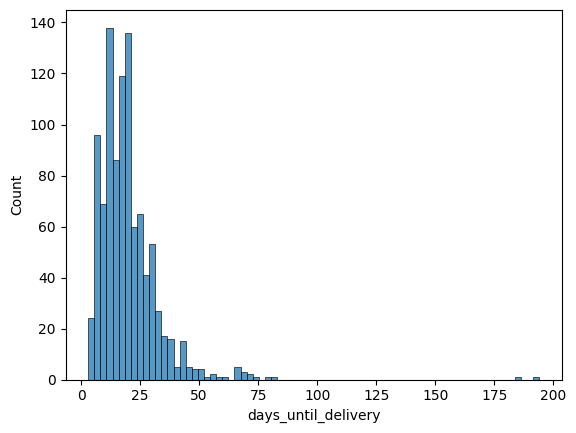

In [3]:
#  Hedefi kontrol et
sns.histplot(data.days_until_delivery);

## 1. Pipeline

👉 `pipe` adlı bir scikit-learn pipeline oluşturun:

- Boyut feature’larından (`dimensions`) bir `volume` feature’ı türetin
- Eğitim için orijinal ürün boyut feature’larını koruyun
- Tüm sayısal feature’ları ölçekleyin
- Kategorik feature’ları encode edin
- Varsayılan ayarlarla bir `Ridge` regresyon estimator’ı ekleyin

**Not:** Bu challenge için holdout yöntemi yok sayılacaktır; yani `train_test_split` kullanmanıza gerek yoktur!

<details><summary><strong>İpuçları</strong></summary>

- Ön işlenmiş feature matrisinizi oluşturmanın birçok yolu vardır (`ColumnTransformer` ve/veya `FeatureUnion` kullanarak). 
    
- Dönüştürülmüş feature matrisiniz garip görünüyorsa, bunun nedeni `OneHotEncoder(sparse_output=True)` varsayılan davranışıyla matrisin "sparse" olarak saklanması olabilir. Bunu tekrar dense bir matrise çevirmek için `.todense()` kullanın.

- Varsayılan NumPy array çıktısı yerine sütun adlarıyla birlikte bir Pandas DataFrame çıktısı almak için, final pipeline’ınızda `.set_output(transform='pandas')` kullanın. (Bunu her bir transformer üzerinde tek tek ayarlamanıza gerek yoktur. Pipeline üzerinde ayarlarsanız, bunu alt aşamalara da aktarır.)

</details>

<br>

<details><summary><strong>Daha fazla ipucu: adım adım yönlendirme</strong> (yalnızca takılırsanız açın)</summary>

Pipeline’ı oluşturmanın en kolay yolu budur.

1. Uzunluk, genişlik ve yükseklik verildiğinde hacmi hesaplayan bir python `function` oluşturun.
2. Aşağıdakilerden oluşan bir hacim hesaplayıcı pipeline oluşturun:
   1. Python `function`’ınızı kullanan bir `FunctionTransformer`.
   1. Ardından bir scaler
3. `ColumnTransformer` kullanarak tam bir preprocessor oluşturun:
   - Orijinal sayısal feature’lar için bir scaler.
   - Kategorik feature’lar için bir encoder.
   - Uzunluk, genişlik ve yükseklik feature’ları için hacim hesaplayıcı pipeline’ınız.
4. Son olarak, tam preprocessor’ınızı ve ardından `Ridge` modelini içeren bir pipeline oluşturun.

</details>

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class VolumeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["volume"] = (
            X["product_length_cm"] * X["product_height_cm"] * X["product_width_cm"]
        )
        return X

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge

In [23]:
X = data.drop("days_until_delivery", axis=1)
y = data["days_until_delivery"]

In [35]:
numeric_features = [
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm"
]

cat_drop = ["customer_state"]
cat_keep = ["seller_state"]

In [36]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),

        # SADECE burada drop var → -1
        ("cat_drop", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_drop),

        # burada drop YOK
        ("cat_keep", OneHotEncoder(handle_unknown="ignore"), cat_keep),
    ],
    remainder="passthrough"  # volume buradan geçiyor
)

In [37]:
pipe = Pipeline(steps=[
    ("volume", VolumeTransformer()),
    ("preprocess", preprocessor),
    ("model", Ridge())
])

#### 🧪  pipe'ını test et

In [38]:
Xt = pipe_test[:-1].fit_transform(X)
print(Xt.shape)

(1000, 30)


In [39]:
from nbresult import ChallengeResult

pipe_test = pipe

# Çökmediğini kontrol edin
assert pipe_test.fit(X, y)

result = ChallengeResult(
    'pipe',
    shape = pipe_test[:-1].fit_transform(X).shape
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/selen/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/selen/data/S17D1-S-Data-Custom-Transformer/tests
plugins: anyio-4.8.0, typeguard-4.4.2, dash-3.3.0
collecting ... collected 1 item

test_pipe.py::TestPipe::test_pipe_not_crashing PASSED                    [100%]

============================== 1 passed in 0.40s ===============================


💯 You can commit your code:

git add tests/pipe.pickle

git commit -m 'Completed pipe step'

git push origin master



## 2. Train ve Predict

👇 `data`’nın tüm eğitim veri setiniz olduğunu varsayalım.

- Bu veri seti üzerinde pipeline’ınızı `cross_validate` edin (❗️düşük $R^2$ skorları beklenmektedir)
- Şimdi de yeni bir sipariş aldığınızı varsayın: `new_data`  
  Teslimat süresini tahmin edin ve sonucu `prediction` adlı değişkende saklayın

In [40]:
new_data = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/custom_transformer_new_order.csv")
new_data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40


In [41]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    pipe,
    X,
    y,
    cv=5,
    scoring="r2"
)

cv_results["test_score"]

/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([-0.0357097 ,  0.06233524,  0.00773525, -0.0027177 ,  0.04534248])

In [42]:
pipe.fit(X, y)

/home/selen/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('volume', VolumeTransformer()),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['product_weight_g',
                                                   'product_length_cm',
                                                   'product_height_cm',
                                                   'product_width_cm']),
                                                 ('cat_drop',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['customer_state']),
                                                 ('cat_keep',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['seller_state'])])),
                ('model', Ridge())])

In [43]:
prediction = pipe.predict(new_data)
prediction

array([16.83841457])

In [44]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'prediction',
    prediction = prediction
)

result.write()
print(result.check())



============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/selen/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/selen/data/S17D1-S-Data-Custom-Transformer/tests
plugins: anyio-4.8.0, typeguard-4.4.2, dash-3.3.0
collecting ... collected 1 item

test_prediction.py::TestPrediction::test_prediction PASSED               [100%]

============================== 1 passed in 0.38s ===============================


💯 You can commit your code:

git add tests/prediction.pickle

git commit -m 'Completed prediction step'

git push origin master



🏁 Tebrikler. Not defterinizi eklemeyi, kaydetmeyi ve göndermeyi unutmayın.